In [1]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
!pip install selenium

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from PIL import Image
from  bs4 import BeautifulSoup
from selenium import webdriver
import networkx as nx
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
phish_data = pd.read_csv(r"C:\Users\hhema\Downloads\phishing_site_urls.csv")

In [5]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [6]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [7]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [8]:
phish_data.isnull().sum()

URL      0
Label    0
dtype: int64

In [9]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [10]:
phish_data.URL[0]


'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [11]:
tokenized_url = phish_data['URL'].apply(tokenizer.tokenize)

In [12]:
tokenizer.tokenize(phish_data.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [13]:
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 7.932019700005185 sec


In [14]:
stemmer = SnowballStemmer("english")

In [15]:
print("stemmed words")
t0 = time.perf_counter()
phish_data['text_stemmed'] = phish_data.URL.map(lambda t : tokenizer.tokenize(t))
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

stemmed words
Time taken 5.249567099963315 sec


In [16]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed
441757,tarahall.com.au/,good,"[tarahall, com, au]","[tarahall, com, au]"
250962,twitter.com/AnnaSegal/status/137393995037937664,good,"[twitter, com, AnnaSegal, status]","[twitter, com, AnnaSegal, status]"
44849,www887.paypal.ca.78630.securessl-910.mx/js/web...,bad,"[www, paypal, ca, securessl, mx, js, web, apps...","[www, paypal, ca, securessl, mx, js, web, apps..."
215144,moono.com/html/jessalyn-gilsig/jessalyn-gilsig...,good,"[moono, com, html, jessalyn, gilsig, jessalyn,...","[moono, com, html, jessalyn, gilsig, jessalyn,..."
80607,www.trellian.com/ecomm/,good,"[www, trellian, com, ecomm]","[www, trellian, com, ecomm]"


In [17]:
print("joining words")
t0 = time.perf_counter()
phish_data['joined_words'] = phish_data['text_stemmed'].map(lambda l :'' .join(l))
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

joining words
Time taken 0.7389966999762692 sec


In [18]:
phish_data.head()

,URL,Label,text_tokenized,text_stemmed,joined_words
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobell, it, ffb, d, dca, cce, f, login, SkyPe...",nobellitffbddcaccefloginSkyPecomencgibinverifi...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",wwwdghjdgfcompaypalcoukcycgibinwebscrcmdhomecu...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbys, com, paypal, cgi, bin, get, int...",serviciosbyscompaypalcgibingetintoherfsecuredi...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, online, americanex...",mailprintakidcomwwwonlineamericanexpresscomind...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydregs, com, wp, content, themes, wi...",thewhiskeydregscomwpcontentthemeswidescreeninc...


In [19]:
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [20]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,joined_words
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobell, it, ffb, d, dca, cce, f, login, SkyPe...",nobellitffbddcaccefloginSkyPecomencgibinverifi...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",wwwdghjdgfcompaypalcoukcycgibinwebscrcmdhomecu...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbys, com, paypal, cgi, bin, get, int...",serviciosbyscompaypalcgibingetintoherfsecuredi...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, online, americanex...",mailprintakidcomwwwonlineamericanexpresscomind...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydregs, com, wp, content, themes, wi...",thewhiskeydregscomwpcontentthemeswidescreeninc...


In [21]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,joined_words
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battle, net, ...",esxcccomjsindexhtmusbattlenetnoghnenrefMdbbwsb...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...",wwweiranvinipncHwVyDaHyEurTugmiXZfnuFWctjeVpEZ...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",wwwinstitutocgrcoowebmediasyqvemdkijRgrdfecmgG...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[Y, ko, D, l, qt]",YkoDlqt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, images, AS, Vies, i, cf, b, vc...",rutafmcomimagesASViesicfbvcFdbgsDvdqtNsrmezwKM...


In [22]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [23]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


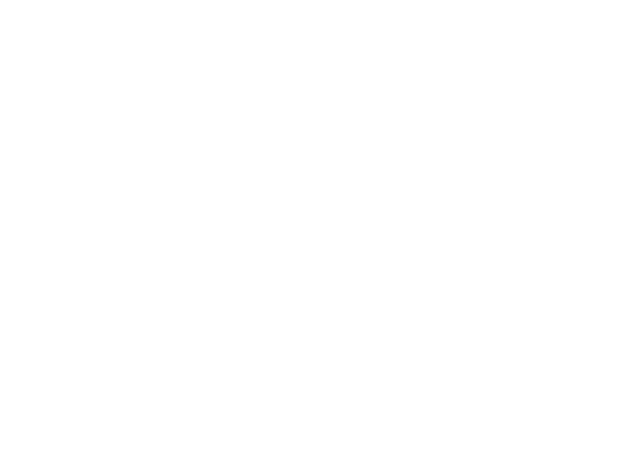

In [24]:
def plot_wordcloud(text,mask=None,max_words = 400,max_font_size=120,figure_size=(24.0,16.0),title= None,title_size=40,image_color=False):
   stopwords = set(STOPWORDS)
   extra = {'com','http'}
   stopwords = stopwords.union(extra)

   wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words = max_words,
                          max_font_size = max_font_size,
                          random_state = 42,
                          mask=mask)
   wordcloud.generate(text)
   plt.figure(figsize=figure_size)
   if image_color:
     image_colors = ImageColorGenerator(mask);
     plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
     plt.title(title, fontdict={'size': title_size,'verticalalignment':'bottom'}) 

   else:
    plt.imshow(wordcloud);
    plt.title(title,fontdict={'size':title_size,'color':'green','verticalalignment': 'bottom'})

plt.axis('off');
plt.tight_layout()

In [25]:
data = good_sites.text_stemmed
data.reset_index(drop=True, inplace=True)

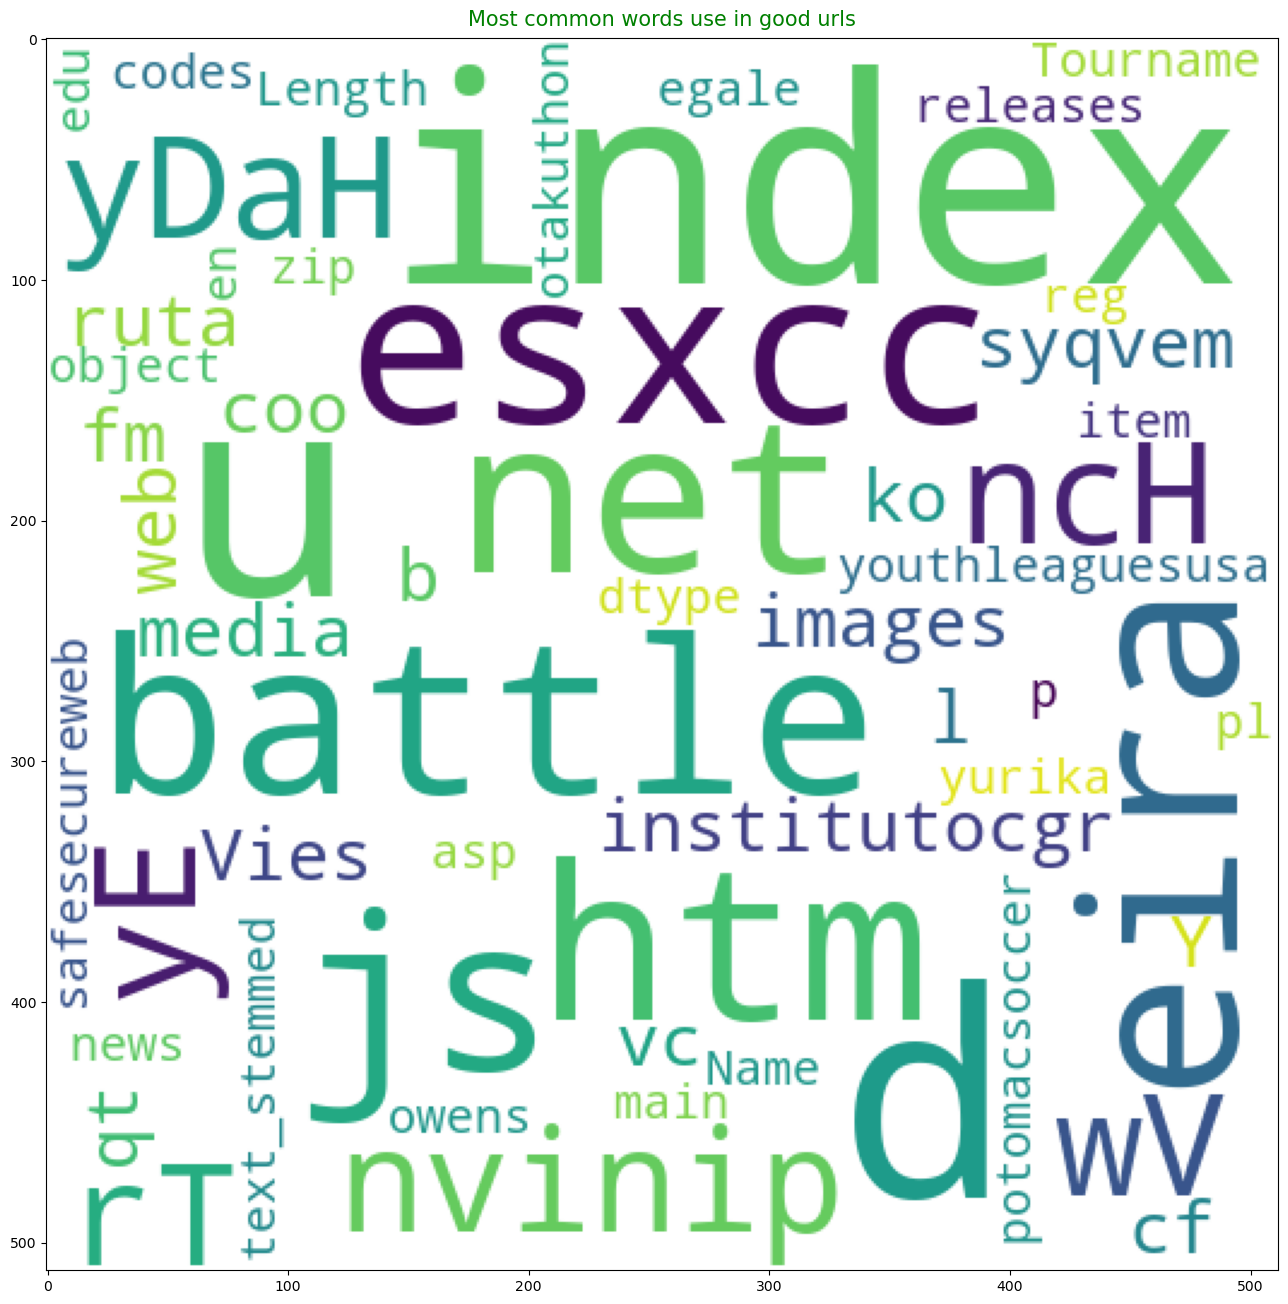

In [26]:
common_text = str(data)
common_mask = np.array(Image.open(r"C:\Users\hhema\Downloads\rect1.png"))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120, 
               title = 'Most common words use in good urls', title_size=15)

In [27]:
data = bad_sites.text_stemmed
data.reset_index(drop=True, inplace=True)

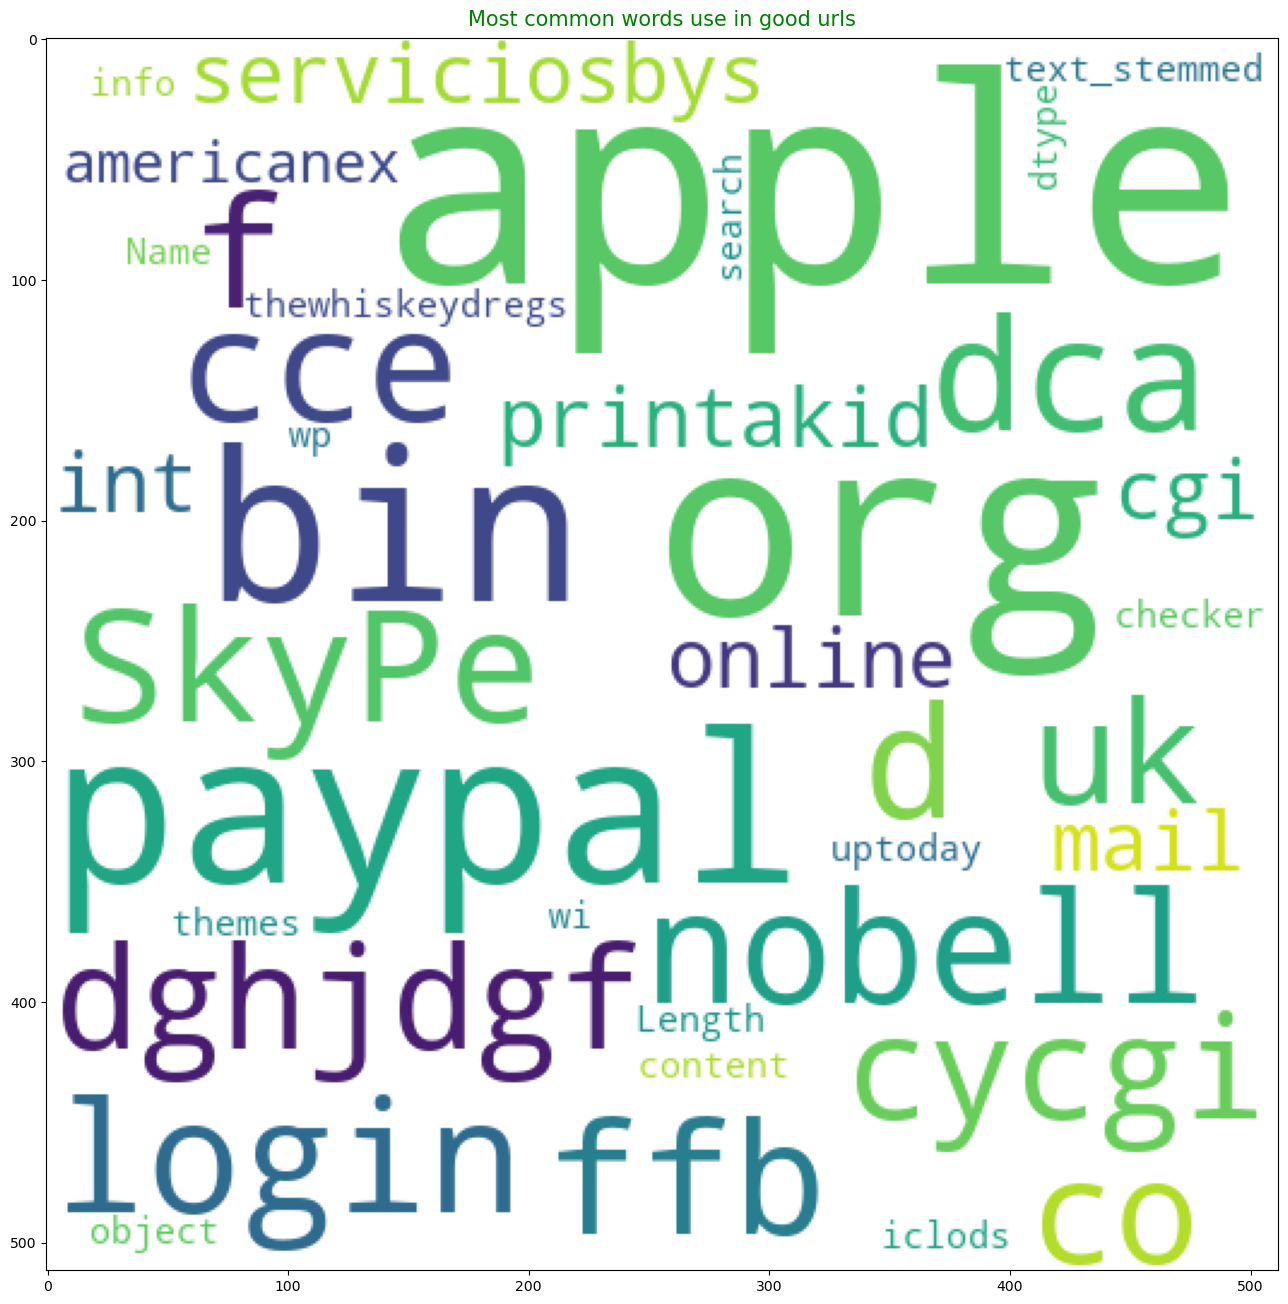

In [28]:
common_text = str(data)
common_mask = np.array(Image.open(r"C:\Users\hhema\Downloads\rect1.png"))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120, 
               title = 'Most common words use in good urls', title_size=15)

In [29]:
!pip install webdriver-manager


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [30]:
!pip install webdriver-manager


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [31]:
!pip install --upgrade selenium webdriver_manager


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [32]:
from selenium import webdriver



In [33]:
from selenium import webdriver

chrome_driver_path = r"C:\Users\hhema\Downloads\chromedriver-win32\chromedriver-win32\chromedriver.exe"
chrome_options = webdriver.ChromeOptions()


chrome_options.add_argument("executable_path=" + chrome_driver_path)

browser = webdriver.Chrome(options=chrome_options)


In [34]:
list_urls = ['https://www.ezeephones.com/','https://www.ezeephones.com/about-us'] #here i take phishing sites 
links_with_text = []

In [35]:
for url in list_urls:
    browser.get(url)
    soup = BeautifulSoup(browser.page_source,"html.parser")
    for line in soup.find_all('a'):
        href = line.get('href')
        links_with_text.append([url, href])

In [36]:

df = pd.DataFrame(links_with_text, columns=["from", "to"])

In [37]:
df.head()

,from,to
0,https://www.ezeephones.com/,https://sedo.com/search/details/?partnerid=144...
1,https://www.ezeephones.com/,https://sedo.com/search/details/?partnerid=144...
2,https://www.ezeephones.com/,https://www.sedo.com/services/parking.php3
3,https://www.ezeephones.com/,#
4,https://www.ezeephones.com/about-us,https://sedo.com/search/details/?partnerid=144...


In [38]:
cv = CountVectorizer()


In [39]:
feature = cv.fit_transform(phish_data.joined_words)

In [46]:
X_train,X_test,y_train,y_test = train_test_split(feature,phish_data.Label)

In [47]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5) 

In [48]:
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

In [49]:
from sklearn.naive_bayes import MultinomialNB

In [52]:
nb_param_grid = {'alpha': [0.01, 0.1, 1, 10]}
nb_grid_search = GridSearchCV(MultinomialNB(), nb_param_grid, cv=5)
nb_grid_search.fit(X_train, y_train)
best_nb = nb_grid_search.best_estimator_

In [53]:
lr_y_pred = best_rf_model.predict(X_test)
print("Logistic Regression Testing Accuracy:", best_rf_model.score(X_test, y_test))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_y_pred))


Logistic Regression Testing Accuracy: 0.8494142146690258
Logistic Regression Classification Report:
              precision    recall  f1-score   support

         bad       1.00      0.47      0.64     39140
        good       0.83      1.00      0.90     98197

    accuracy                           0.85    137337
   macro avg       0.91      0.74      0.77    137337
weighted avg       0.88      0.85      0.83    137337



In [54]:
nb_y_pred = best_nb.predict(X_test)
print("\nMultinomial Naive Bayes Testing Accuracy:", best_nb.score(X_test, y_test))
print("Multinomial Naive Bayes Classification Report:")
print(classification_report(y_test, nb_y_pred))


Multinomial Naive Bayes Testing Accuracy: 0.8494142146690258
Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

         bad       1.00      0.47      0.64     39140
        good       0.83      1.00      0.90     98197

    accuracy                           0.85    137337
   macro avg       0.91      0.74      0.77    137337
weighted avg       0.88      0.85      0.83    137337



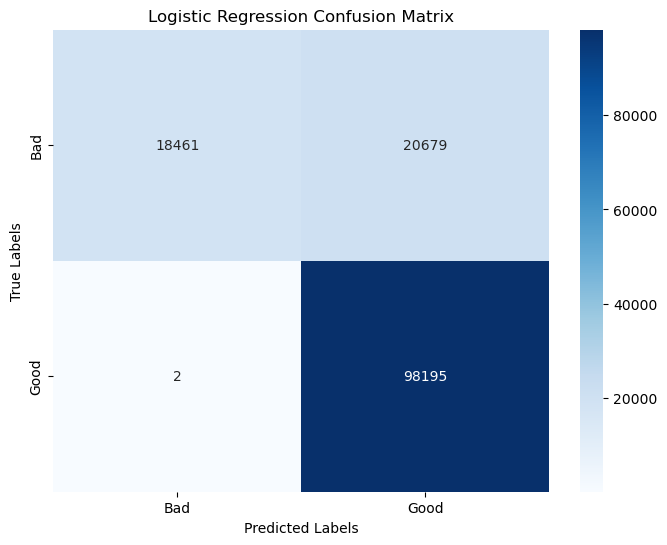

In [55]:
lr_cm = confusion_matrix(y_test, lr_y_pred) 
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

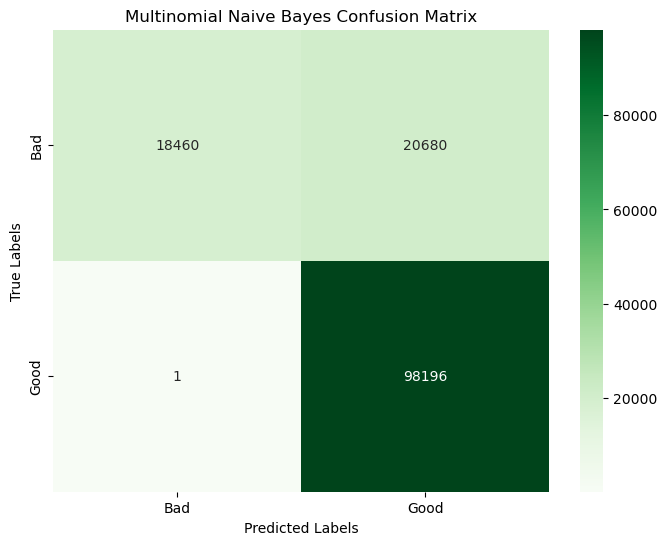

In [56]:
nb_cm = confusion_matrix(y_test, nb_y_pred) 
plt.figure(figsize=(8, 6))
sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Greens", xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Multinomial Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [57]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer=RegexpTokenizer(r'[A-Za-z]+').tokenize, stop_words='english'),LogisticRegression())

In [58]:
X_train,X_test,y_train,y_test = train_test_split(phish_data.URL,phish_data.Label)

In [59]:
pipeline_ls.fit(X_train,y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [60]:
pipeline_ls.score(X_test,y_test)

0.9674741693789729

Training Accuracy: 0.9807844003407693
Testing Accuracy: 0.9674741693789729

Classification Report

              precision    recall  f1-score   support

         Bad       0.92      0.97      0.94     36860
        Good       0.99      0.97      0.98    100477

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337

Confusion matrix


<Axes: >

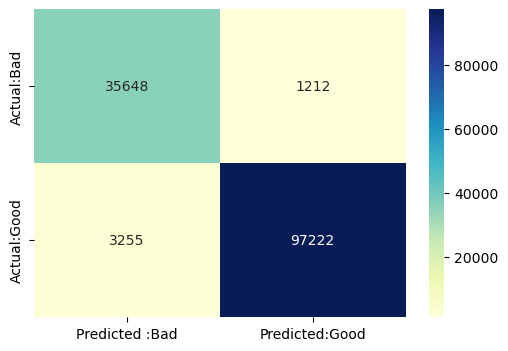

In [61]:
print('Training Accuracy:',pipeline_ls.score(X_train,y_train))
print('Testing Accuracy:',pipeline_ls.score(X_test,y_test))
mat1 = pd.DataFrame(confusion_matrix(pipeline_ls.predict(X_test),y_test),
                    columns =['Predicted :Bad','Predicted:Good'],
                    index = ['Actual:Bad','Actual:Good'])

print('\nClassification Report\n')
print(classification_report(pipeline_ls.predict(X_test),y_test,
                           target_names =['Bad','Good']))

print('Confusion matrix')
plt.figure(figsize=(6,4))
sns.heatmap(mat1,annot=True,fmt='d',cmap="YlGnBu")

In [62]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [63]:
import pickle

# Replace '/path/to/directory/' with the actual directory where you want to save the file.
file_path = r"C:\Users\hhema\Downloads\phishing.pkl"

# Save the model to the specified file path.
pickle.dump(pipeline_ls, open(file_path, 'wb'))


In [64]:
loaded_model = pickle.load(open('phishing.pkl','rb'))
result = loaded_model.score(X_test,y_test)
print(result)

0.9674741693789729
